## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Фролов Михаил Алексеевич

In [21]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [22]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [23]:
images_train, labels_train = next(iter(train_loader))

In [24]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

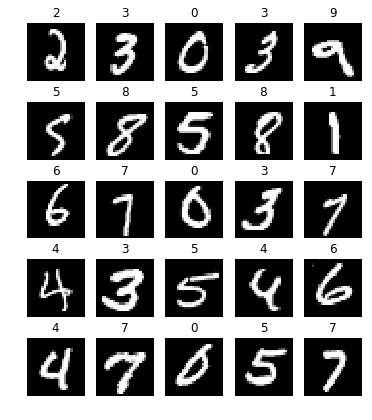

In [25]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [26]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [27]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [28]:
def new_linear_layer_he(input_size, output_size):
    mean = 0.0
    std = np.sqrt(2.0/output_size)
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [29]:
def new_linear_layer_xavier(input_size, output_size):
    mean = 0.0
    interval = np.sqrt(6.0/(output_size+input_size))
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    layer.bias.data.zero_()
    layer.weight.data.uniform_(-interval, interval)
    return layer
                            
    

In [37]:
##### YOUR CODE HERE #####
##ReLu
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax(1))
network = nn.Sequential(*layers)
#network
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()


forward 0.990386784077
forward 1.05768489838
forward 1.04099464417
forward 1.07231080532
forward 1.07790124416
forward 1.09802758694
forward 1.12851893902
forward 1.12467133999
forward 1.11673021317
forward 1.08373582363
forward 0.989417016506
forward 0.972773551941
backward 0.00403574714437
backward 0.00406965706497
backward 0.00401154626161
backward 0.00397604471073
backward 0.00395655957982
backward 0.0039860396646
backward 0.00403114641085
backward 0.00402418011799
backward 0.00403699185699
backward 0.00408608093858
backward 0.00406566355377
backward 0.00410659750924


In [38]:
##### YOUR CODE HERE #####
##Tanh
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax(1))
network = nn.Sequential(*layers)
#network
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.990386784077
forward 0.762507677078
forward 0.650413274765
forward 0.602837622166
forward 0.580051541328
forward 0.568475842476
forward 0.564895153046
forward 0.562393188477
forward 0.557187020779
forward 0.556973993778
forward 0.550935208797
forward 0.551649570465
backward 0.00375379063189
backward 0.00397973880172
backward 0.00421631336212
backward 0.00443941075355
backward 0.00470237946138
backward 0.0049349325709
backward 0.00513328891248
backward 0.00531186163425
backward 0.0054475707002
backward 0.0054173246026
backward 0.00511201517656
backward 0.00391979608685


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [40]:
##### YOUR CODE HERE #####
##He ReLu
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer_he(784,500))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer_he(500,500))
    layers.append(nn.ReLU())
layers.append(new_linear_layer_he(500,10))
layers.append(nn.LogSoftmax(1))
network = nn.Sequential(*layers)
#network
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()


forward 0.990386784077
forward 1.00921630859
forward 1.02071452141
forward 1.01982426643
forward 1.07572031021
forward 1.13745105267
forward 1.15130639076
forward 1.1104631424
forward 1.10328388214
forward 1.08367502689
forward 1.0824328661
forward 1.09059858322
backward 0.00435866508633
backward 0.00444493861869
backward 0.00440437532961
backward 0.00453696446493
backward 0.0044622994028
backward 0.00434568105265
backward 0.0043526198715
backward 0.00448017707095
backward 0.00452632363886
backward 0.00453827809542
backward 0.00458669289947
backward 0.00459725921974


In [41]:
##### YOUR CODE HERE #####
##He Tanh
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer_he(784,500))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer_he(500,500))
    layers.append(nn.Tanh())
layers.append(new_linear_layer_he(500,10))
layers.append(nn.LogSoftmax(1))
network = nn.Sequential(*layers)
#network
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()


forward 0.990386784077
forward 0.761836290359
forward 0.650751769543
forward 0.603135347366
forward 0.577447533607
forward 0.565503358841
forward 0.558751642704
forward 0.558281958103
forward 0.560109257698
forward 0.559390604496
forward 0.558885872364
forward 0.552587330341
backward 0.00382650457323
backward 0.00408069696277
backward 0.00423776591197
backward 0.00446988502517
backward 0.00470706308261
backward 0.00491897528991
backward 0.00516306748614
backward 0.00543865840882
backward 0.00557926017791
backward 0.00552039733157
backward 0.00514242239296
backward 0.00403666635975


In [42]:
##### YOUR CODE HERE #####
##Xavier Tanh
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer_xavier(784,500))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer_xavier(500,500))
    layers.append(nn.Tanh())
layers.append(new_linear_layer_xavier(500,10))
layers.append(nn.LogSoftmax(1))
network = nn.Sequential(*layers)
#network
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()


forward 0.990386784077
forward 0.651101231575
forward 0.500726521015
forward 0.418334662914
forward 0.363301515579
forward 0.326331496239
forward 0.289495944977
forward 0.265996336937
forward 0.249307021499
forward 0.23403480649
forward 0.225807517767
forward 0.213380083442
backward 0.0030047558248
backward 0.00058145535877
backward 0.000559476728085
backward 0.000519780558534
backward 0.000487954530399
backward 0.000460064213257
backward 0.000417416304117
backward 0.000375995674403
backward 0.000325331144268
backward 0.000272454926744
backward 0.000213786610402
backward 0.000141591168358


In [43]:
##### YOUR CODE HERE #####
##Xavier ReLu
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer_xavier(784,500))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer_xavier(500,500))
    layers.append(nn.ReLU())
layers.append(new_linear_layer_xavier(500,10))
layers.append(nn.LogSoftmax(1))
network = nn.Sequential(*layers)
#network
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.990386784077
forward 0.630281567574
forward 0.435037195683
forward 0.316065877676
forward 0.232810616493
forward 0.161036044359
forward 0.105167426169
forward 0.0712470635772
forward 0.0495382100344
forward 0.0359983630478
forward 0.0258724484593
forward 0.0180870275944
backward 0.00300038419664
backward 0.000444462522864
backward 0.000300199812045
backward 0.000213965031435
backward 0.000150524967466
backward 0.00010686848691
backward 7.37802402e-05
backward 5.18479318998e-05
backward 3.68598011846e-05
backward 2.59338521573e-05
backward 1.84437540156e-05
backward 1.29659219965e-05


<i> 1.4 Сделайте выводы по первой части </i>

Можно сделать вывод, что He хорошо работает для ReLu.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

Epoch 9... (Train/Test) NLL: 0.023/0.074	Accuracy: 0.992/0.979

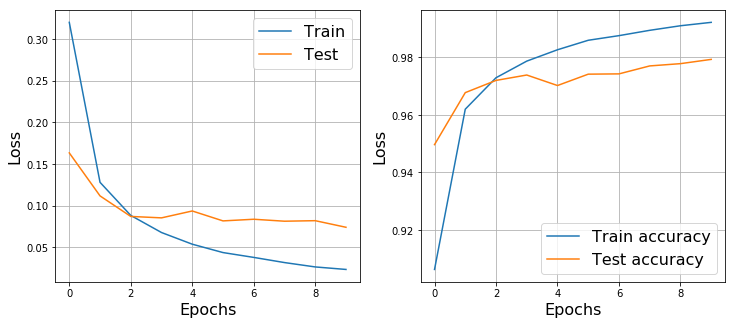

In [48]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax(1))

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.212/0.110	Accuracy: 0.938/0.968

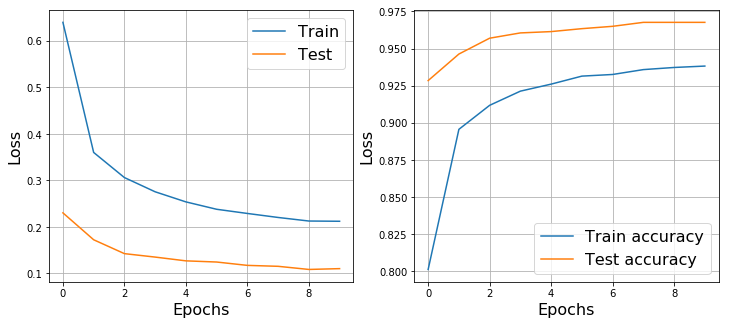

In [45]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

In [46]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

Epoch 9... (Train/Test) NLL: 0.123/0.091	Accuracy: 0.961/0.972

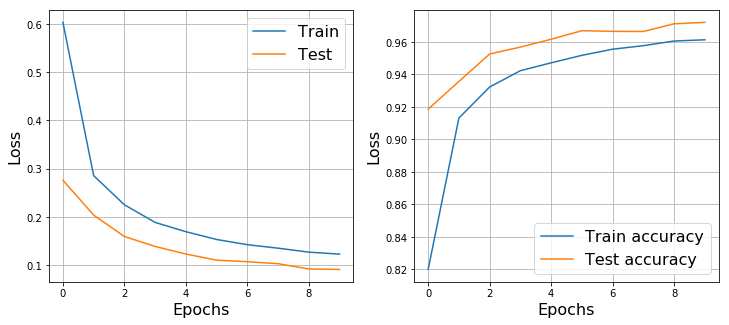

In [47]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [ ]:
##### YOUR CODE HERE #####

Epoch 19... (Train/Test) NLL: 0.096/0.078	Accuracy: 0.971/0.978

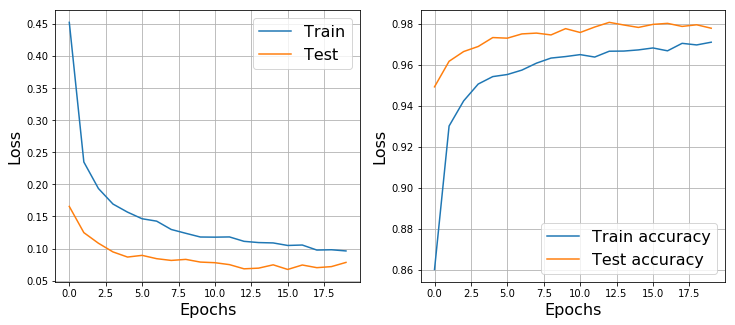

In [49]:
#DropOut
network = nn.Sequential(nn.Linear(784, 200),
                      nn.Dropout(0.5),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.Dropout(0.5),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))
#train_loss_do, test_loss_do, train_acc_do, test_acc_do = 
train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.108/0.082	Accuracy: 0.967/0.977

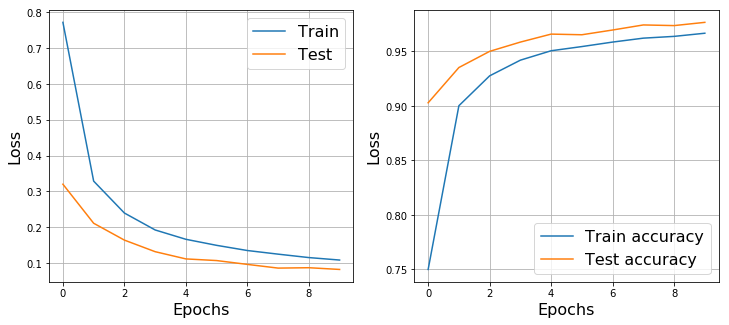

In [58]:
#DropConnect
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 10, p=0.5),
                        nn.LogSoftmax(1))

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

Можно сделать вывод, что с Dropout/Dropconnect сеть сходится быстрее, чем без. Достигается это путем борьбы с переобучением. В принципе, DropOut и DropConnect дают в среднем примерно одинаковую точность для разных сетей.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [79]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(-1, keepdim=True)) / (1e-6 + x.std(-1, keepdim=True))
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.019/0.092	Accuracy: 0.994/0.976

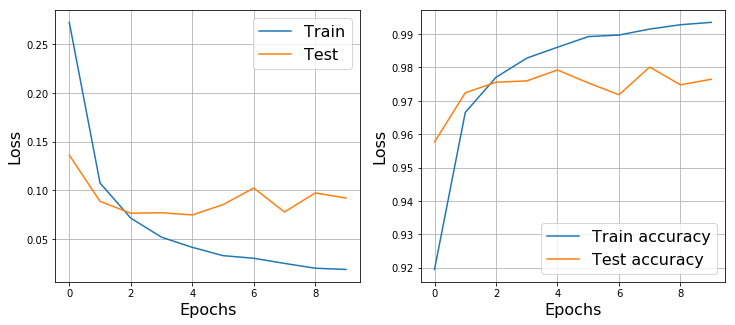

In [61]:
##### YOUR CODE HERE #####
#Not normalization
network = nn.Sequential(nn.Linear(784, 200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.012/0.084	Accuracy: 0.996/0.978

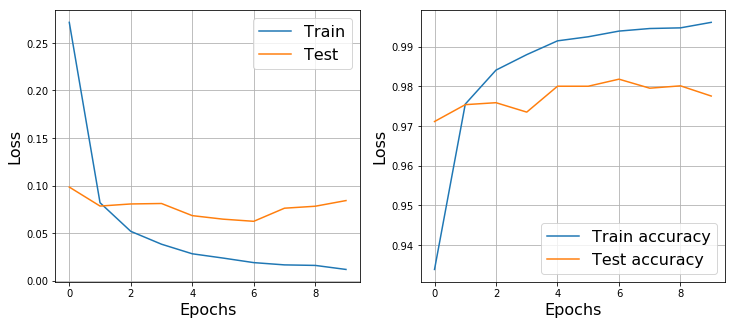

In [62]:
#Batch normalization
network = nn.Sequential(nn.Linear(784, 200),
                      nn.BatchNorm1d(200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.BatchNorm1d(200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.021/0.075	Accuracy: 0.993/0.978

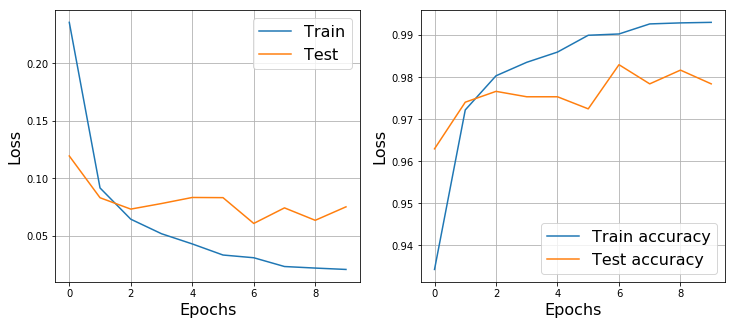

In [87]:
#Layer normalization
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      LayerNormalization(),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

Batch normalization и Layer normalization дают примерно одинаковое качество улучшения.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: